In [1]:
import numpy as np
import cv2
import torch
import kornia
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm.notebook import tqdm
from scipy.spatial.distance import cdist
from skimage.transform import warp, ProjectiveTransform
import random

In [2]:
def plot_inlier_matches(ax, img1, img2, inliers):
    """
    Plot the matches between two images according to the matched keypoints
    :param ax: plot handle
    :param img1: left image
    :param img2: right image
    :inliers: x,y in the first image and x,y in the second image (Nx4)
    """
    max_width = max(img1.shape[1], img2.shape[1])
    max_height = max(img1.shape[0], img2.shape[0])
    img1 = cv2.resize(img1, (max_width, max_height))
    img2 = cv2.resize(img2, (max_width, max_height))

    res = np.hstack([img1, img2])
    ax.set_aspect('equal')
    ax.imshow(res, cmap='gray')
    
    ax.plot(inliers[:,0], inliers[:,1], '+r')
    ax.plot(inliers[:,2] + img1.shape[1], inliers[:,3], '+r')
    ax.plot([inliers[:,0], inliers[:,2] + img1.shape[1]],
            [inliers[:,1], inliers[:,3]], 'r', linewidth=0.4)
    ax.axis('off')

# PART A

## 1. Preprocessing 

In [3]:
image_left = cv2.convertScaleAbs(cv2.cvtColor(cv2.imread('parliament-left.jpg').astype(np.float32), cv2.COLOR_BGR2GRAY))
image_right = cv2.convertScaleAbs(cv2.cvtColor(cv2.imread('parliament-right.jpg').astype(np.float32), cv2.COLOR_BGR2GRAY))

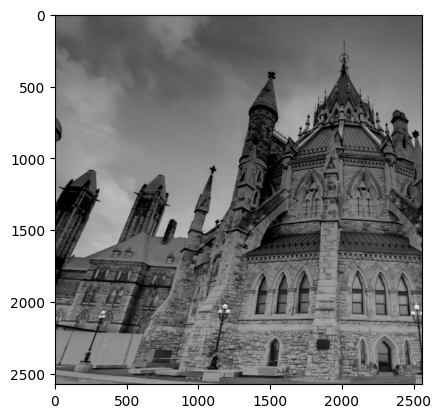

In [4]:
plt.imshow(image_left ,cmap='gray')

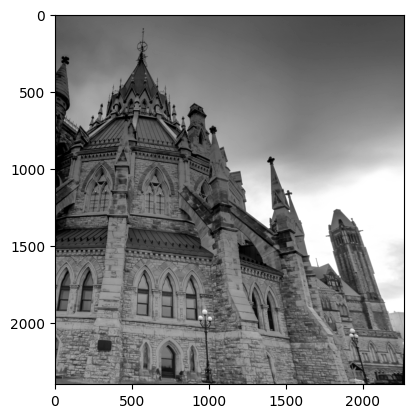

In [5]:
plt.imshow(image_right,cmap='gray')

## 2. Detect keypoints and extract descriptors

In [6]:
sift_features = cv2.SIFT_create()

In [7]:
keypoints1, descriptors1 = sift_features.detectAndCompute(image_left, None)
keypoints2, descriptors2 = sift_features.detectAndCompute(image_right, None)

In [8]:
image1_with_keypoints = cv2.drawKeypoints(image_left, keypoints1, None)
image2_with_keypoints = cv2.drawKeypoints(image_right, keypoints2, None)


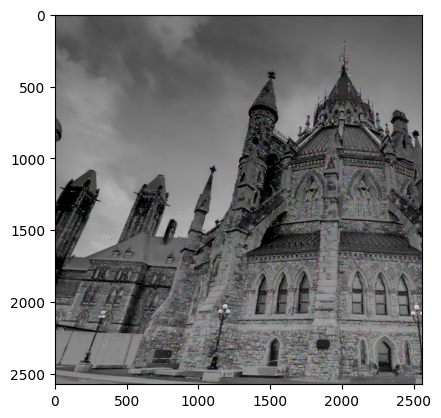

In [9]:
plt.imshow(image1_with_keypoints)

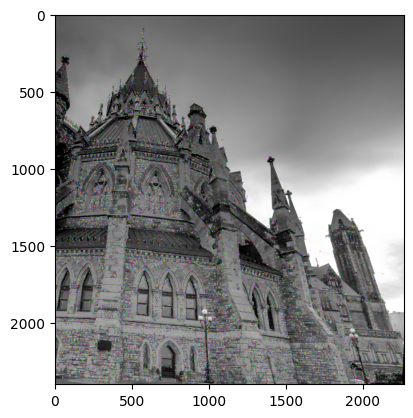

In [10]:
plt.imshow(image2_with_keypoints)

## 3. Match features 

In [11]:
descriptors1_T = torch.from_numpy(descriptors1).float().squeeze(0)
descriptors2_T = torch.from_numpy(descriptors2).float().squeeze(0)
matches = kornia.feature.match_snn(descriptors1_T, descriptors2_T, 0.08)

In [12]:
distances = cdist(descriptors2, descriptors2, metric='sqeuclidean')

## Prune features

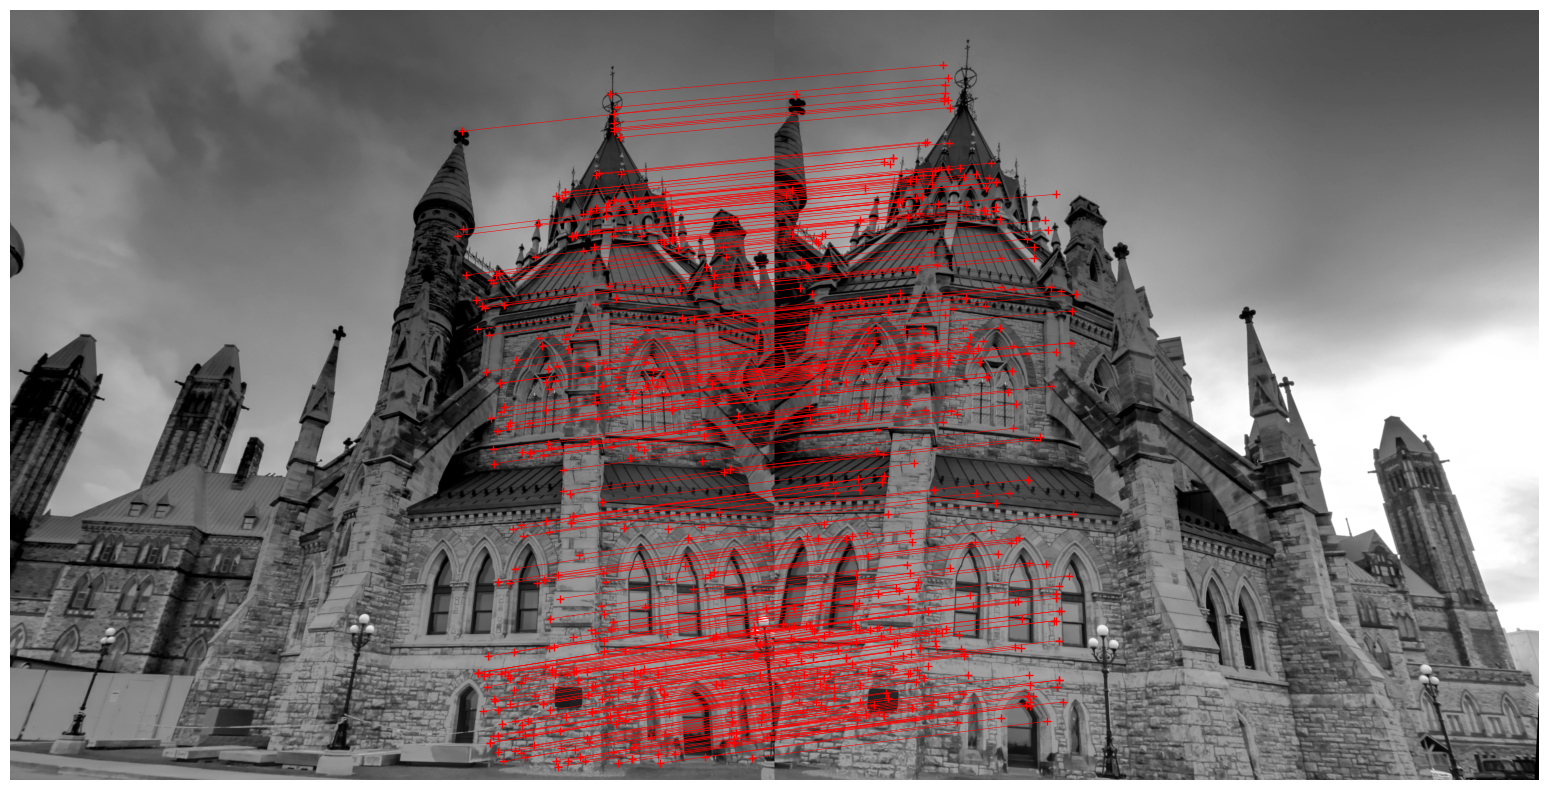

In [13]:
computed_inliers = np.zeros((len(matches[1]), 4))
for i, match in enumerate(matches[1]):
    idx1, idx2 = match
    x1, y1 = keypoints1[idx1].pt
    x2, y2 = keypoints2[idx2].pt
    computed_inliers[i] = [x1, y1, x2, y2]

# Plot inlier matches
fig, ax = plt.subplots(figsize=(20,10))
plot_inlier_matches(ax, image_left, image_right, computed_inliers)


In [14]:
computed_inliers

array([[1495.39501953,  753.90124512,   36.89516068,  619.37908936],
       [1511.6895752 ,  405.42675781,   70.60673523,  279.25576782],
       [1515.69885254,  733.40142822,   57.73231125,  600.32830811],
       ...,
       [2528.9909668 , 2000.20031738,  984.02758789, 1891.41210938],
       [2530.87817383, 1789.27075195,  996.82220459, 1685.27246094],
       [2531.87353516, 2431.00683594,  964.85845947, 2313.06958008]])


## 5. Robust transformation estimation 

In [15]:
def affine_transform_ransac(computed_inliers, threshold, num_iteration):
    # In this case, we use the minimum number of matches required to compute an affine transformation is 3
    min_num_matches = 3

    # Initialize variables
    max_num_inliers = 0
    best_affine_matrix = None

    # Perform RANSAC iterations
    for i in range(num_iteration):
        # Randomly select minimum number of matches to compute the affine transformation
        random_sample = random.sample(list(computed_inliers), min_num_matches)
        src_points = np.float32([random_sample[i][:2] for i in range(min_num_matches)]).reshape(-1, 1, 2)
        dst_points = np.float32([random_sample[i][2:] for i in range(min_num_matches)]).reshape(-1, 1, 2)

        # Compute the affine transformation using inverse transformation
        A = np.zeros((2 * min_num_matches, 6))
        b = np.zeros((2 * min_num_matches, 1))
        for j in range(min_num_matches):
            point = src_points[j][0]
            x, y = point[0], point[1]
            
            point1 = dst_points[j][0]
            u, v = point1[0], point1[1]
            A[2*j, :] = [x, y, 1, 0, 0, 0]
            A[2*j+1, :] = [0, 0, 0, x, y, 1]
            b[2*j, 0] = u
            b[2*j+1, 0] = v
        try:
            A_inv = np.linalg.inv(A)
        except np.linalg.LinAlgError:
            continue
        affine_matrix = np.dot(A_inv, b)
        affine_matrix = np.vstack([affine_matrix.reshape(2, 3), [0, 0, 1]])

        # Compute number of inliers using the computed affine transformation
        num_inliers = 0
        for j in range(len(computed_inliers)):
            src_point = np.array([computed_inliers[j][0], computed_inliers[j][1], 1])
            dst_point = np.array([computed_inliers[j][2], computed_inliers[j][3], 1])
            transformed_src_point = np.dot(affine_matrix, src_point)
            if np.linalg.norm(dst_point[:2] - transformed_src_point[:2]) < threshold:
                num_inliers += 1

        # Update best affine transformation if more inliers are found
        if num_inliers > max_num_inliers:
            max_num_inliers = num_inliers
            best_affine_matrix = affine_matrix

    # Return the best affine transformation matrix
    return best_affine_matrix


In [16]:
A = affine_transform_ransac(computed_inliers,0.8,2000)

In [17]:
A

array([[ 9.78445312e-01, -5.12026846e-02, -1.38789651e+03],
       [ 5.11715876e-02,  9.78225926e-01, -1.94623255e+02],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [18]:

def to_pytorch(img):
    img_t = torch.from_numpy(img)
    img_t = img_t.permute(2,0,1)
    img_t = img_t.unsqueeze(0)
    return img_t

In [19]:
def from_pytorch(img_t):
    img_t = img_t.squeeze(0)
    img_t = img_t.permute(2,1,0)
    img_t = img_t.numpy()
    return img_t

In [20]:
left_image = cv2.cvtColor(cv2.imread('parliament-left.jpg').astype(np.float32)/ 255, cv2.COLOR_BGR2RGB)
right_image = cv2.cvtColor(cv2.imread('parliament-right.jpg').astype(np.float32)/255, cv2.COLOR_BGR2RGB)

In [ ]:
#getting H,W,C of each image
height_left, width_left, channel_left = left_image.shape
height_right, width_right, channel_right = right_image.shape
#converting to tensor     
left = to_pytorch(left_image)
right =to_pytorch(right_image)

#size of the mosiac image
corners = [[0, 0, 1], [width_left, 0, 1], [width_left, height_left, 1], [0, height_left, 1]]
corners_new = [np.dot(A, corner) for corner in corners]
corners_new = np.array(corners_new).T 
x_news = corners_new[0] / corners_new[2]
y_news = corners_new[1] / corners_new[2]
y_min = min(y_news)
x_min = min(x_news)
height_newimg = int(round(abs(y_min) + height_right))
width_newimg = int(round(abs(x_min) + width_right))
size = (width_newimg, height_newimg)

TM = np.array([[1, 0, -x_min], [0, 1, -y_min], [0, 0, 1]])
X = np.dot(TM, A)
warped_left = cv2.warpPerspective(left_image,X,size)
warped_right = cv2.warpPerspective(right_image,TM,size)
height_r, width_r, channel_r = right_image.shape
height_new = int(round(abs(y_min) + height_r))
width_new = int(round(abs(x_min) + width_r))
size = (width_new, height_new)   

# Warp images using kornia.geometry.transform.warp_perspective
warped_lx = kornia.geometry.transform.warp_perspective(left, torch.from_numpy(X).float().unsqueeze(0).inverse(), dsize=size, align_corners=True)
warped_rx = kornia.geometry.transform.warp_perspective(right, torch.from_numpy(TM).float().unsqueeze(0).inverse(), dsize=size,align_corners=True)
#converting back to numpy
wraped_left = from_pytorch(warped_lx)
wraped_right = from_pytorch(warped_rx)
black_pixel = np.zeros(3) 
    
# creating a mosiac
for i in range(warped_right.shape[0]):
    for j in range(warped_right.shape[1]):
        pixel_left = warped_left[i, j, :]
        pixel_right = warped_right[i, j, :]
            
        if not np.array_equal(pixel_left, black_pixel) and np.array_equal(pixel_right, black_pixel):
            warped_left[i, j, :] = pixel_left
        elif np.array_equal(pixel_left, black_pixel) and not np.array_equal(pixel_right, black_pixel):
            warped_left[i, j, :] = pixel_right
        elif not np.array_equal(pixel_left, black_pixel) and not np.array_equal(pixel_right, black_pixel):
            warped_left[i, j, :] = (pixel_left + pixel_right) / 2
        else:
            pass
                  
mosaic = warped_left[:warped_right.shape[0], :warped_right.shape[1], :]

In [ ]:
plt.imshow(mosaic)

# Part B